In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [7]:
# напишем функцию для получения данных
# для проведения кросс-валидации разобьём обучающий датасет (88 800 изображений) на трейн и тест датасеты

def get_data(limit=None):
    df = pd.read_csv('emnist-letters-train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0  # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

if __name__ == '__main__':
    X, Y = get_data(88800)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

# KNeighborsClassifier

Метод KNN получается самым трудозатратным по времени для обучения модели. Однозначно не следует запускать обучение по всему датасету, необходимо обучать модель на срезанном наборе данных. В дальнейшем классификатор также будет применяться в комбинации с уменьшением размерности PCA.

In [3]:
# напишем цикл, который перебирает число k соседей и соответствующую среднюю точность прогноза

cv_scores=[]
for k in range(1,9):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain, Ytrain)
    scores = knn.score(Xtest,Ytest)
    cv_scores.append([k, scores.mean(),scores.std()])
df_scores = pd.DataFrame(cv_scores, columns=['k', 'Accuracy', 'STD'])

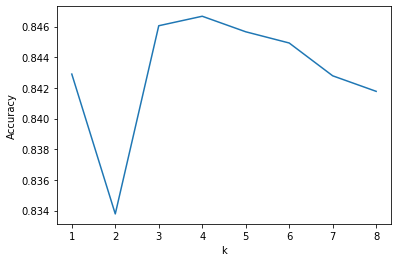

In [4]:
# для выбора оптимального числа k визуализируем значение score (ось 'Accuracy') в соответствие с числом соседей

sns.lineplot(x="k", y="Accuracy", data=df_scores)

Запускал обучение KNN несколько раз, оптимальным получалось значение k от 3 до 5.
Используем k = 4.
Один из самых затратных по времени для обучения методов.

In [8]:
# получаем тестовый датасет (14 800 изображений)

new_test = pd.read_csv('emnist-letters-test-data-h.csv')
new_test = new_test / 255

In [6]:
# обучение модели с выбранным числом k

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(Xtrain, Ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [7]:
# делаем прогноз

pred = knn.predict(new_test)

In [8]:
# представим полученные прогнозные значения в виде датафрейма, добавив столбец new_id в качестве индекса

pred_knn = pd.DataFrame(np.array(pred), columns=['label'],index=new_test.index)

In [9]:
pred_knn['new_id']=range(1,14801)
pred_knn = pred_knn[['new_id', 'label']]
pred_knn

,id,label
0,1,1
1,2,1
2,3,1
3,4,15
4,5,1
...,...,...
14795,14796,19
14796,14797,19
14797,14798,19
14798,14799,19


In [10]:
# выгрузим получившийся датафрейм с рассчитанными прогнозными значениями

pred_knn.to_csv('pred_knn.csv', index=False)

# DecisionTreeClassifier

Попробуем использовать в качестве классификатора дерево принятия решений. Я подбирал различные параметры max_depth, ccp_alpha, min_samples_leaf.

In [11]:
decision_tree = DecisionTreeClassifier()

In [12]:
decision_tree.fit(Xtrain, Ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
decision_tree.score(Xtest, Ytest)

0.6734797297297297

Хороших результатов с помощью классификатора добиться не получилось. Самый высокий показатель точности при этом выдаёт модель вообще без указания параметров.

# Logistic Regression

Используем линейную регрессию. Создаём экземпляр класса. Создаём экземпляр класса, обучаем, тестируем, смотрим результат.

In [14]:
logistic_regression = LogisticRegression()

In [15]:
logistic_regression.fit(Xtrain, Ytrain)

C:\Users\Mark.Voytov\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
logistic_regression.score(Xtest, Ytest)

0.71615990990991

Результат немного лучше, чем у DecisionTreeClassifier, но всё равно довольно низкий.

# Naive Bayes

Используем Наивный байесовский классификатор. Попробуем классифицировать данные с помощью GaussianNB и BernoulliNB.

### GaussianNB

In [17]:
gaussian_nb = GaussianNB()

In [18]:
gaussian_nb.fit(Xtrain, Ytrain)

GaussianNB(priors=None, var_smoothing=1e-09)

In [19]:
gaussian_nb.score(Xtest, Ytest)

0.35309684684684683

Работает быстро, но для этой задачи не подходит.

### BernoulliNB

In [20]:
bernulli_nb = BernoulliNB(alpha=0.01)

In [21]:
bernulli_nb.fit(Xtrain, Ytrain)

BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)

In [22]:
bernulli_nb.score(Xtest, Ytest)

0.5663851351351351

Аналогично моментально выдаётся результат, но тоже низкий.

# LinearSVC

Набор данных довольно большой, поэтому будем использовать LinearSVC. Я подставлял разные значения параметров kernel, degree, C, gamma

In [23]:
svc = SVC(kernel = 'poly', degree = 1, C = 10, gamma = 0.001)

In [24]:
svc.fit(Xtrain, Ytrain)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.001, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
svc.score(Xtest, Ytest)

0.7928490990990991

Модель обучается около 10 минут, поэтому выкладывать прочие примеры с разными значениями гиперпараметров, наверно, нет смысла.

# PCA

Попробуем уменьшить размерность пространства при помощи метода PCA: сравним результаты, сделаем выводы.

In [9]:
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X))

In [5]:
# для анализа посмотрим на первые 100 кумулятивных дисперсий

(X_pca.var()/X_pca.var().sum()).cumsum().head(100)

0     0.094784
1     0.161099
2     0.219093
3     0.265037
4     0.310179
        ...   
95    0.937363
96    0.938275
97    0.939155
98    0.940010
99    0.940844
Length: 100, dtype: float64

In [6]:
# снизим размерность данных до 100 признаков

X_pca = pca.transform(X)[:,:100]
X_pca.shape

(88799, 100)

In [7]:
# разделим X_pca на обучающий и тренировочный датасеты

Xtrain_pca, Xtest_pca, Ytrain_pca, Ytest_pca = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

In [30]:
# применим SVM, выдавший ранее результат 0.7928

svc = SVC(kernel = 'poly', degree = 1, C = 10, gamma = 0.001)
svc.fit(Xtrain_pca, Ytrain_pca)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.001, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
svc.score(Xtest_pca, Ytest_pca)

0.7901463963963964

В результате снижения размерности точность метода Linear SVC осталась примерно на том же уровне.

In [32]:
# построим прогноз для new_test,
# сначала у этого набора данных тоже нужно уменьшить размерность до 100 признаков

new_test_pca = pca.transform(new_test)[:,:100]

In [33]:
pred_pca = svc.predict(new_test_pca)

In [34]:
pred1_pca = pd.DataFrame(np.array(pred_pca), columns=['label'])

In [35]:
pred1_pca['new_id']=range(1,14801)
pred1_pca = pred1_pca[['new_id', 'label']]

In [36]:
pred1_pca.to_csv('pred1_pca.csv', index=False)

Теперь применим KNN для X_pca. Проверим, будет ли для данных со сниженной размерностью количество соседей k = 4 наилучшим.

In [37]:
cv_scores=[]
for k in range(1,16):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain_pca, Ytrain_pca)
    scores = knn.score(Xtest_pca,Ytest_pca)
    cv_scores.append([k, scores.mean(),scores.std()])
df_scores = pd.DataFrame(cv_scores, columns=['k', 'Accuracy', 'STD'])

,k,Accuracy,STD
0,1,0.858108,0.0
1,2,0.847410,0.0
2,3,0.859572,0.0
3,4,0.858784,0.0
4,5,0.859459,0.0
5,6,0.859291,0.0
6,7,0.857601,0.0
7,8,0.856532,0.0
8,9,0.855124,0.0
9,10,0.852365,0.0


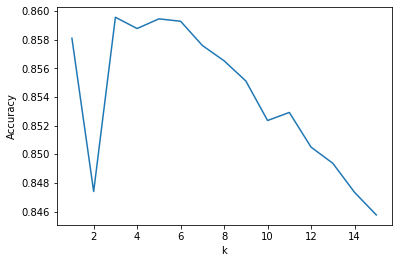

In [38]:
sns.lineplot(x="k", y="Accuracy", data=df_scores)
df_scores

Попробуем выбрать значение k равным 5.

In [39]:
pred_pca_knn5 = knn.predict(new_test_pca)

pred_pca_knn5 = pd.DataFrame(np.array(pred_pca_knn5), columns=['label'])

pred_pca_knn5['new_id']=range(1,14801)
pred_pca_knn5 = pred_pca_knn5[['new_id', 'label']]

pred_pca_knn5.to_csv('pred_pca_knn5.csv', index=False)

Попробуем изменить количество главных компонент и посмотрим, какая будет точность на тестовой выборке. Будем менять количество компонент от 50 до 200 с шагом 50.

In [40]:
for n in range(50,250,50):
    X_pca = pca.transform(X)[:,:n]
    Xtrain_pca, Xtest_pca, Ytrain_pca, Ytest_pca = train_test_split(X_pca, Y, test_size=0.2, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(Xtrain_pca, Ytrain_pca)
    print(n, "components" , end=': ')
    print(knn.score(Xtest_pca, Ytest_pca))

50 components: 0.872240990990991
100 components: 0.8594594594594595
150 components: 0.8556306306306306
200 components: 0.8532094594594595


Видим, что при использовании PCA, применяя KNeighborsClassifier, мы можем значительно увелить точность прогноза. Таким образом, уменьшение размерности данных было оправдано.

# RandomForestClassifier

Дополнительно попробуем использовать в качестве классификатора метод Random forest. Сравним результаты.

In [3]:
# Лучший результат дало использование RandomForestClassifier с параметрами: критерий, максимальная глубина дерева, количество деревьев

RF = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators = 300, random_state=0)

In [4]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
RF.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [5]:
RF.score(Xtest,Ytest)

0.8782657657657658

In [8]:
pred_RF = RF.predict(new_test)
pred_RF = pd.DataFrame(np.array(pred_RF), columns=['label'])

pred_RF['new_id']=range(1,14801)
pred_RF = pred_RF[['new_id', 'label']]

pred_RF.to_csv('pred_RF.csv', index=False)

RandomForestClassifier выдаёт самый точный результат по сравнению с предыдущими классификаторами.
В Public Leaderboard на кэггле выдаёт score 0.8662.

Попробуем снизить размерность, посмотрим, улучшит ли это результат.

In [11]:
Xtrain2, Xtest2, Ytrain2, Ytest2 = train_test_split(X_pca, Y, test_size=0.2, random_state=42)
RF.fit(Xtrain2, Ytrain2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [12]:
RF.score(Xtest2,Ytest2)

0.7586711711711712

При использовании PCA к RandomForestClassifier результат ухудшается.

# CatBoostClassifier

Дополнительно попробуем использовать CatBoost.
В качестве изменяемого гиперпараметра тут выступает число деревьев iterations (по умолчанию - 1000).
Значение score на тестовой выборке для разных iterations составило:
- 100: 0.7995;
- 1000: 0.8706;
- 1500: 0.8766;
- 2000: 0.8765;
- 2500: 0.8797;
- 3000: 0.8768;
- 3500: 0.8769;
- 5000: 0.8763.

In [14]:
catboost = CatBoostClassifier(iterations=3000)

In [5]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
catboost.fit(Xtrain, Ytrain)

Learning rate set to 0.038867
0:	learn: 3.1179129	total: 8.43s	remaining: 7h 1m 11s
1:	learn: 3.0041362	total: 18.6s	remaining: 7h 44m 17s
2:	learn: 2.9050898	total: 28.4s	remaining: 7h 53m 17s
3:	learn: 2.8208630	total: 38.7s	remaining: 8h 3m 20s
4:	learn: 2.7371745	total: 48.8s	remaining: 8h 6m 48s
5:	learn: 2.6699436	total: 58.9s	remaining: 8h 9m 47s
6:	learn: 2.6043479	total: 1m 9s	remaining: 8h 11m 50s
7:	learn: 2.5461734	total: 1m 18s	remaining: 8h 11m 12s
8:	learn: 2.4847387	total: 1m 28s	remaining: 8h 12m 28s
9:	learn: 2.4338227	total: 1m 39s	remaining: 8h 14m 35s
10:	learn: 2.3882946	total: 1m 49s	remaining: 8h 14m 2s
11:	learn: 2.3390432	total: 1m 59s	remaining: 8h 14m 32s
12:	learn: 2.2945078	total: 2m 9s	remaining: 8h 14m 33s
13:	learn: 2.2512791	total: 2m 19s	remaining: 8h 14m 25s
14:	learn: 2.2113536	total: 2m 29s	remaining: 8h 14m 47s
15:	learn: 2.1716007	total: 2m 39s	remaining: 8h 14m 53s
16:	learn: 2.1357616	total: 2m 49s	remaining: 8h 15m 3s
17:	learn: 2.0991099	tota

In [6]:
catboost.score(Xtest,Ytest)

0.8768018018018018

In [7]:
pred_catboost = catboost.predict(new_test)
pred_catboost = pd.DataFrame(np.array(pred_catboost), columns=['label'])

pred_catboost['new_id']=range(1,14801)
pred_catboost = pred_catboost[['new_id', 'label']]

pred_catboost.to_csv('pred_catboost_3000.csv', index=False)

CatBoost на тестовой выборке выдаёт результат, сравнимый с Random forest. Я перепробовал разные значения iterations, т.к. этот параметр даёт наилучший результат.

Посмотрим, как снижение размерности может повлиять на CatBoost.

In [15]:
Xtrain1, Xtest1, Ytrain1, Ytest1 = train_test_split(X_pca, Y, test_size=0.2, random_state=42)
catboost.fit(Xtrain1, Ytrain1)

Learning rate set to 0.176653
0:	learn: 2.8864376	total: 11.4s	remaining: 1h 34m 26s
1:	learn: 2.5941893	total: 25.1s	remaining: 1h 44m 21s
2:	learn: 2.4239337	total: 38.6s	remaining: 1h 46m 37s
3:	learn: 2.2637964	total: 53.4s	remaining: 1h 50m 19s
4:	learn: 2.1547325	total: 1m 6s	remaining: 1h 50m 28s
5:	learn: 2.0427760	total: 1m 20s	remaining: 1h 50m 7s
6:	learn: 1.9361954	total: 1m 33s	remaining: 1h 50m 10s
7:	learn: 1.8579826	total: 1m 47s	remaining: 1h 49m 51s
8:	learn: 1.7819796	total: 2m	remaining: 1h 49m 56s
9:	learn: 1.7286749	total: 2m 15s	remaining: 1h 50m 56s
10:	learn: 1.6740665	total: 2m 29s	remaining: 1h 50m 59s
11:	learn: 1.6196181	total: 2m 43s	remaining: 1h 50m 39s
12:	learn: 1.5732347	total: 2m 57s	remaining: 1h 50m 56s
13:	learn: 1.5228431	total: 3m 12s	remaining: 1h 51m 9s
14:	learn: 1.4813908	total: 3m 26s	remaining: 1h 51m 12s
15:	learn: 1.4435491	total: 3m 39s	remaining: 1h 50m 42s
16:	learn: 1.4024791	total: 3m 53s	remaining: 1h 50m 30s
17:	learn: 1.3690355	t

In [16]:
catboost.score(Xtest1,Ytest1)

0.8378378378378378

Я изменял параметр iterations в CatBoost и перезапускал модель. В целом, результат всегда оказывался ниже, чем до применения PCA. Также я изменял через переменную X_pca (X_pca = pca.transform(X)[:,:100]) количество признаков (пробовал также значения 50, 150), но результат не стал лучше. Таким образом, в этом случае, как и с Random forest, снижение размерности ухудшает точность классификатора.

### Вывод

Так как исследование выполнялось в течение нескольких дней, вывод по результатам работы был написан по отдельности после каждого классификатора. 
В лидерборде в качестве лучшего результата использовано предсказание Random Forest.